# Coaxial

This example shows how to create a project from scratch in HFSS and Icepak.
This includes creating a setup, solving it, and creating postprocessing outputs.

Keywords: **Multiphysics**, **HFSS**, **Icepak**.

## Perform imports and define constants

Perform required imports.

In [1]:
import os
import tempfile
import time

In [2]:
import ansys.aedt.core
from ansys.aedt.core.visualization.plot.pdf import AnsysReport

Define constants.

In [3]:
AEDT_VERSION = "2024.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [4]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Launch AEDT and initialize HFSS

Launch AEDT and initialize HFSS. If there is an active HFSS design, the ``hfss``
object is linked to it. Otherwise, a new design is created.

In [5]:
hfss = ansys.aedt.core.Hfss(
    project=os.path.join(temp_folder.name, "Icepak_HFSS_Coupling"),
    design="RF",
    version=AEDT_VERSION,
    non_graphical=NG_MODE,
    new_desktop=True,
    solution_type="Modal",
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_029f5467-5db1-450a-879b-fbf6de1d947c.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 53898


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 824.


PyAEDT INFO: Project Icepak_HFSS_Coupling has been created.


PyAEDT INFO: Added design 'RF' of type HFSS.


PyAEDT INFO: Aedt Objects correctly read


## Define parameters

Parameters can be instantiated by defining them as a key used for the application
instance as demonstrated in the following code. The prefix ``$`` is used to define
a project-wide scope for the parameter. Otherwise, the parameter scope is limited to
the current design.

In [6]:
hfss["$coax_dimension"] = "100mm"  # Project-wide scope.
udp = hfss.modeler.Position(0, 0, 0)
hfss["inner"] = "3mm"  # Local "Design" scope.

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 1sec


## Create coaxial and cylinders

Create a coaxial and three cylinders. You can apply parameters
directly using the `ansys.aedt.core.modeler.Primitives3D.Primitives3D.create_cylinder()`
method. You can assign a material directly to the object creation action.
Optionally, you can assign a material using the `assign_material()` method.

In [7]:
o1 = hfss.modeler.create_cylinder(
    orientation=hfss.PLANE.ZX,
    origin=udp,
    radius="inner",
    height="$coax_dimension",
    num_sides=0,
    name="inner",
)
o2 = hfss.modeler.create_cylinder(
    orientation=hfss.PLANE.ZX,
    origin=udp,
    radius=8,
    height="$coax_dimension",
    num_sides=0,
    name="teflon_based",
)
o3 = hfss.modeler.create_cylinder(
    orientation=hfss.PLANE.ZX,
    origin=udp,
    radius=10,
    height="$coax_dimension",
    num_sides=0,
    name="outer",
)

PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


## Assign colors

Assign colors to each primitive.

In [8]:
o1.color = (255, 0, 0)
o2.color = (0, 255, 0)
o3.color = (255, 0, 0)
o3.transparency = 0.8
hfss.modeler.fit_all()

## Assign materials

Assign materials. You can assign materials either directly when creating the primitive,
which was done for ``id2``, or after the object is created.

In [9]:
o1.material_name = "Copper"
o3.material_name = "Copper"

## Perform modeler operations

Perform modeler operations. You can subtract, add, and perform other operations
using either the object ID or object name.

In [10]:
hfss.modeler.subtract(o3, o2, True)
hfss.modeler.subtract(o2, o1, True)

True

## Assign mesh operations

Most mesh operations are accessible using the ``mesh`` property,
which is an instance of the ``ansys.aedt.core.modules.MeshIcepak.IcepakMesh`` class.

This code shows how to use several common mesh operations.

In [11]:
hfss.mesh.assign_initial_mesh_from_slider(level=6)
hfss.mesh.assign_model_resolution(assignment=[o1.name, o3.name], defeature_length=None)
hfss.mesh.assign_length_mesh(
    assignment=o2.faces, inside_selection=False, maximum_length=1, maximum_elements=2000
)

PyAEDT INFO: Mesh class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Mesh class has been initialized! Elapsed time: 0m 0sec


## Create HFSS sources

The RF power dissipated in the HFSS model acts as the thermal
source for in Icepak. The ``create_wave_port_between_objects()`` method
is used to assign the RF ports that inject RF power into the HFSS
model. If ``add_pec_cap=True``, then the method
creates a perfectly conducting (lossless) cap covering the port.

In [12]:
hfss.wave_port(
    assignment="inner",
    reference="outer",
    integration_line=1,
    create_port_sheet=True,
    create_pec_cap=True,
    name="P1",
)

hfss.wave_port(
    assignment="inner",
    reference="outer",
    integration_line=4,
    create_pec_cap=True,
    create_port_sheet=True,
    name="P2",
)

port_names = hfss.get_all_sources()
hfss.modeler.fit_all()

PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmprzn2hvcr.ansys/Icepak_HFSS_Coupling.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmprzn2hvcr.ansys/Icepak_HFSS_Coupling.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.015573501586914062


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Deleted 1 Objects: inner_ObjectFromEdge1.


PyAEDT INFO: Deleted 1 Objects: inner_ObjectFromEdge2.


PyAEDT INFO: Connection Correctly created


PyAEDT INFO: Boundary Wave Port P1 has been correctly created.


PyAEDT INFO: Deleted 1 Objects: inner_ObjectFromEdge3.


PyAEDT INFO: Deleted 1 Objects: inner_ObjectFromEdge4.


PyAEDT INFO: Connection Correctly created


PyAEDT INFO: Boundary Wave Port P2 has been correctly created.


## Set up simulation

Create a HFSS setup with default values. After its creation,
you can change values and update the setup. The ``update()`` method returns a Boolean
value.

In [13]:
hfss.set_active_design(hfss.design_name)
setup = hfss.create_setup("MySetup")
setup.props["Frequency"] = "1GHz"
setup.props["BasisOrder"] = 2
setup.props["MaximumPasses"] = 1

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Returning found Desktop session with PID 824!


PyAEDT INFO: Project Icepak_HFSS_Coupling set to active.


PyAEDT INFO: Aedt Objects correctly read


## Create frequency sweep

The HFSS frequency sweep defines the RF frequency range over which the RF power is
injected into the structure.

In [14]:
sweepname = hfss.create_linear_count_sweep(
    setup="MySetup",
    units="GHz",
    start_frequency=0.8,
    stop_frequency=1.2,
    num_of_freq_points=401,
    sweep_type="Interpolating",
)

PyAEDT INFO: Linear count sweep Sweep_ZWSTNH has been correctly created.


## Create Icepak model

After an HFSS setup has been defined, the model can be lnked to an Icepak
design. The coupled physics analysis can then be run. The `FieldAnalysis3D.copy_solid_bodies_from()`
method imports a model from HFSS into Icepak, including all material definitions.

In [15]:
ipk = ansys.aedt.core.Icepak(design="CalcTemp", version=AEDT_VERSION)
ipk.copy_solid_bodies_from(hfss)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Returning found Desktop session with PID 824!


PyAEDT INFO: No project is defined. Project Icepak_HFSS_Coupling exists and has been read.


PyAEDT INFO: Added design 'CalcTemp' of type Icepak.


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


True

## Link RF thermal source

The RF loss in HFSS is used as the thermal source in Icepak.

In [16]:
surfaceobj = ["inner", "outer"]
ipk.assign_em_losses(
    design=hfss.design_name,
    setup="MySetup",
    sweep="LastAdaptive",
    map_frequency="1GHz",
    surface_objects=surfaceobj,
    parameters=["$coax_dimension", "inner"],
)

PyAEDT INFO: Mapping EM losses.


PyAEDT INFO: EM losses mapped from design: RF.


## Set direction of gravity

Set the direction of gravity for convection in Icepak. Gravity drives a temperature gradient
due to the dependence of gas density on temperature.

In [17]:
ipk.edit_design_settings(hfss.GRAVITY.ZNeg)

True

## Set up Icepak Project

The initial solution setup applies default values that can subsequently
be modified as shown in the following code.
The ``props`` property enables access to all solution settings.

The ``update`` function applies the settings to the setup. The setup creation
process is identical for all tools.

In [18]:
setup_ipk = ipk.create_setup("SetupIPK")
setup_ipk.props["Convergence Criteria - Max Iterations"] = 3

### Access Icepak solution properties

Setup properties are accessible through the ``props`` property as
an ordered dictionary. You can use the ``keys()`` method to retrieve all settings for
the setup.

Find properties that contain the string ``"Convergence"`` and print the default values.

In [19]:
conv_props = [k for k in setup_ipk.props.keys() if "Convergence" in k]
print("Here are some default setup properties:")
for p in conv_props:
    print('"' + p + '" -> ' + str(setup_ipk.props[p]))

Here are some default setup properties:
"Convergence Criteria - Flow" -> 0.001
"Convergence Criteria - Energy" -> 1e-07
"Convergence Criteria - Turbulent Kinetic Energy" -> 0.001
"Convergence Criteria - Turbulent Dissipation Rate" -> 0.001
"Convergence Criteria - Specific Dissipation Rate" -> 0.001
"Convergence Criteria - Discrete Ordinates" -> 1e-06
"Convergence Criteria - Max Iterations" -> 3
"GPU Convergence Criteria - Flow" -> 0.001
"GPU Convergence Criteria - Energy" -> 1e-05
"GPU Convergence Criteria - Turbulent Kinetic Energy" -> 0.001
"GPU Convergence Criteria - Turbulent Dissipation Rate" -> 0.001
"GPU Convergence Criteria - Specific Dissipation Rate" -> 0.001
"GPU Convergence Criteria - Discrete Ordinates" -> 1e-05
"GPU Convergence Criteria - Joule Heating" -> 1e-07


### Edit or review mesh parameters

Edit or review the mesh parameters. After a mesh is created, you can access
a mesh operation to edit or review parameter values.

In [20]:
airbox = ipk.modeler.get_obj_id("Region")
ipk.modeler[airbox].display_wireframe = True
airfaces = ipk.modeler.get_object_faces(airbox)
ipk.assign_openings(airfaces)

PyAEDT INFO: Opening Assigned


Save the project and attach to the Icepak instance.

In [21]:
hfss.save_project()
ipk = ansys.aedt.core.Icepak(version=AEDT_VERSION)
ipk.solution_type = ipk.SOLUTIONS.Icepak.SteadyTemperatureAndFlow
ipk.modeler.fit_all()

PyAEDT INFO: Project Icepak_HFSS_Coupling Saved correctly


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Returning found Desktop session with PID 824!


PyAEDT INFO: No project is defined. Project Icepak_HFSS_Coupling exists and has been read.


PyAEDT INFO: Active Design set to CalcTemp


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmprzn2hvcr.ansys/Icepak_HFSS_Coupling.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmprzn2hvcr.ansys/Icepak_HFSS_Coupling.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.046930551528930664


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


## Solve models

Solve the Icepak and HFSS models.

In [22]:
ipk.setups[0].analyze(cores=NUM_CORES, tasks=NUM_CORES)
hfss.save_project()
hfss.modeler.fit_all()
hfss.setups[0].analyze()

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Icepak correctly changed.


PyAEDT INFO: Solving design setup SetupIPK


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Icepak correctly changed.


PyAEDT INFO: Design setup SetupIPK solved correctly in 0.0h 1.0m 30.0s


PyAEDT INFO: Project Icepak_HFSS_Coupling Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Solving design setup MySetup


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Design setup MySetup solved correctly in 0.0h 0.0m 31.0s


### Plot and export results

Generate field plots in the HFSS project and export them as images.

PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmprzn2hvcr.ansys/Icepak_HFSS_Coupling.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmprzn2hvcr.ansys/Icepak_HFSS_Coupling.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.048058509826660156


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


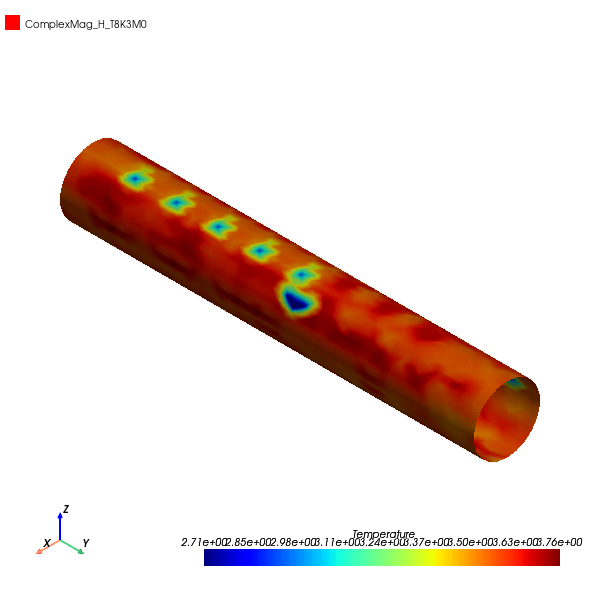

In [23]:
quantity_name = "ComplexMag_H"
intrinsic = {"Freq": hfss.setups[0].props["Frequency"], "Phase": "0deg"}
surface_list = hfss.modeler.get_object_faces("outer")
plot1 = hfss.post.create_fieldplot_surface(
    assignment=surface_list,
    quantity=quantity_name,
    setup=hfss.nominal_adaptive,
    intrinsics=intrinsic,
)

hfss.post.plot_field_from_fieldplot(
    plot1.name,
    project_path=temp_folder.name,
    mesh_plot=False,
    image_format="jpg",
    view="isometric",
    show=False,
    plot_cad_objs=False,
    log_scale=False,
    file_format="aedtplt",
)

## Generate animation from field plots

Generate an animation from field plots using PyVista.

C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


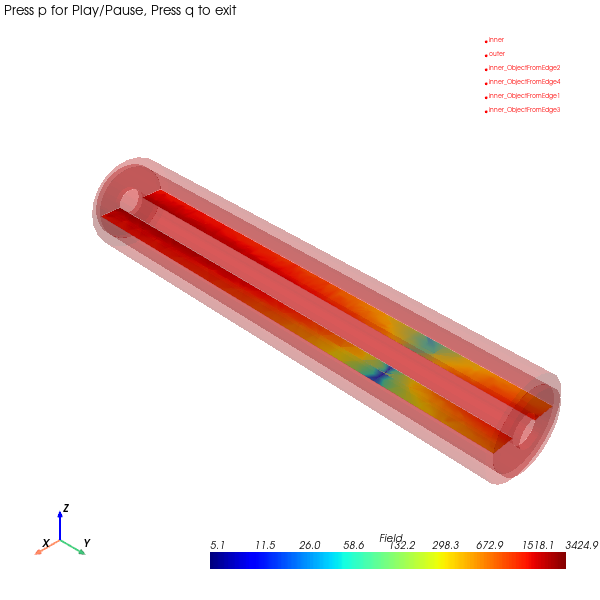

Total Time 13.803018808364868


In [24]:
start = time.time()
cutlist = ["Global:XY"]
phase_values = [str(i * 5) + "deg" for i in range(18)]

animated = hfss.post.plot_animated_field(
    quantity="Mag_E",
    assignment=cutlist,
    plot_type="CutPlane",
    setup=hfss.nominal_adaptive,
    intrinsics=intrinsic,
    export_path=temp_folder.name,
    variation_variable="Phase",
    variations=phase_values,
    show=False,
    export_gif=False,
    log_scale=True,
)
animated.gif_file = os.path.join(temp_folder.name, "animate.gif")

# Set off_screen to False to visualize the animation.
# animated.off_screen = False

animated.animate()

end_time = time.time() - start
print("Total Time", end_time)

## Postprocess

Create Icepak plots and export them as images using the same functions that
were used early. Only the quantity is different.

In [25]:
setup_name = ipk.existing_analysis_sweeps[0]
intrinsic = ""
surface_list = ipk.modeler.get_object_faces("inner") + ipk.modeler.get_object_faces(
    "outer"
)
plot5 = ipk.post.create_fieldplot_surface(surface_list, quantity="SurfTemperature")

hfss.save_project()

PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Project Icepak_HFSS_Coupling Saved correctly


True

Plot results using Matplotlib.

PyAEDT INFO: Solution Data Correctly Loaded.


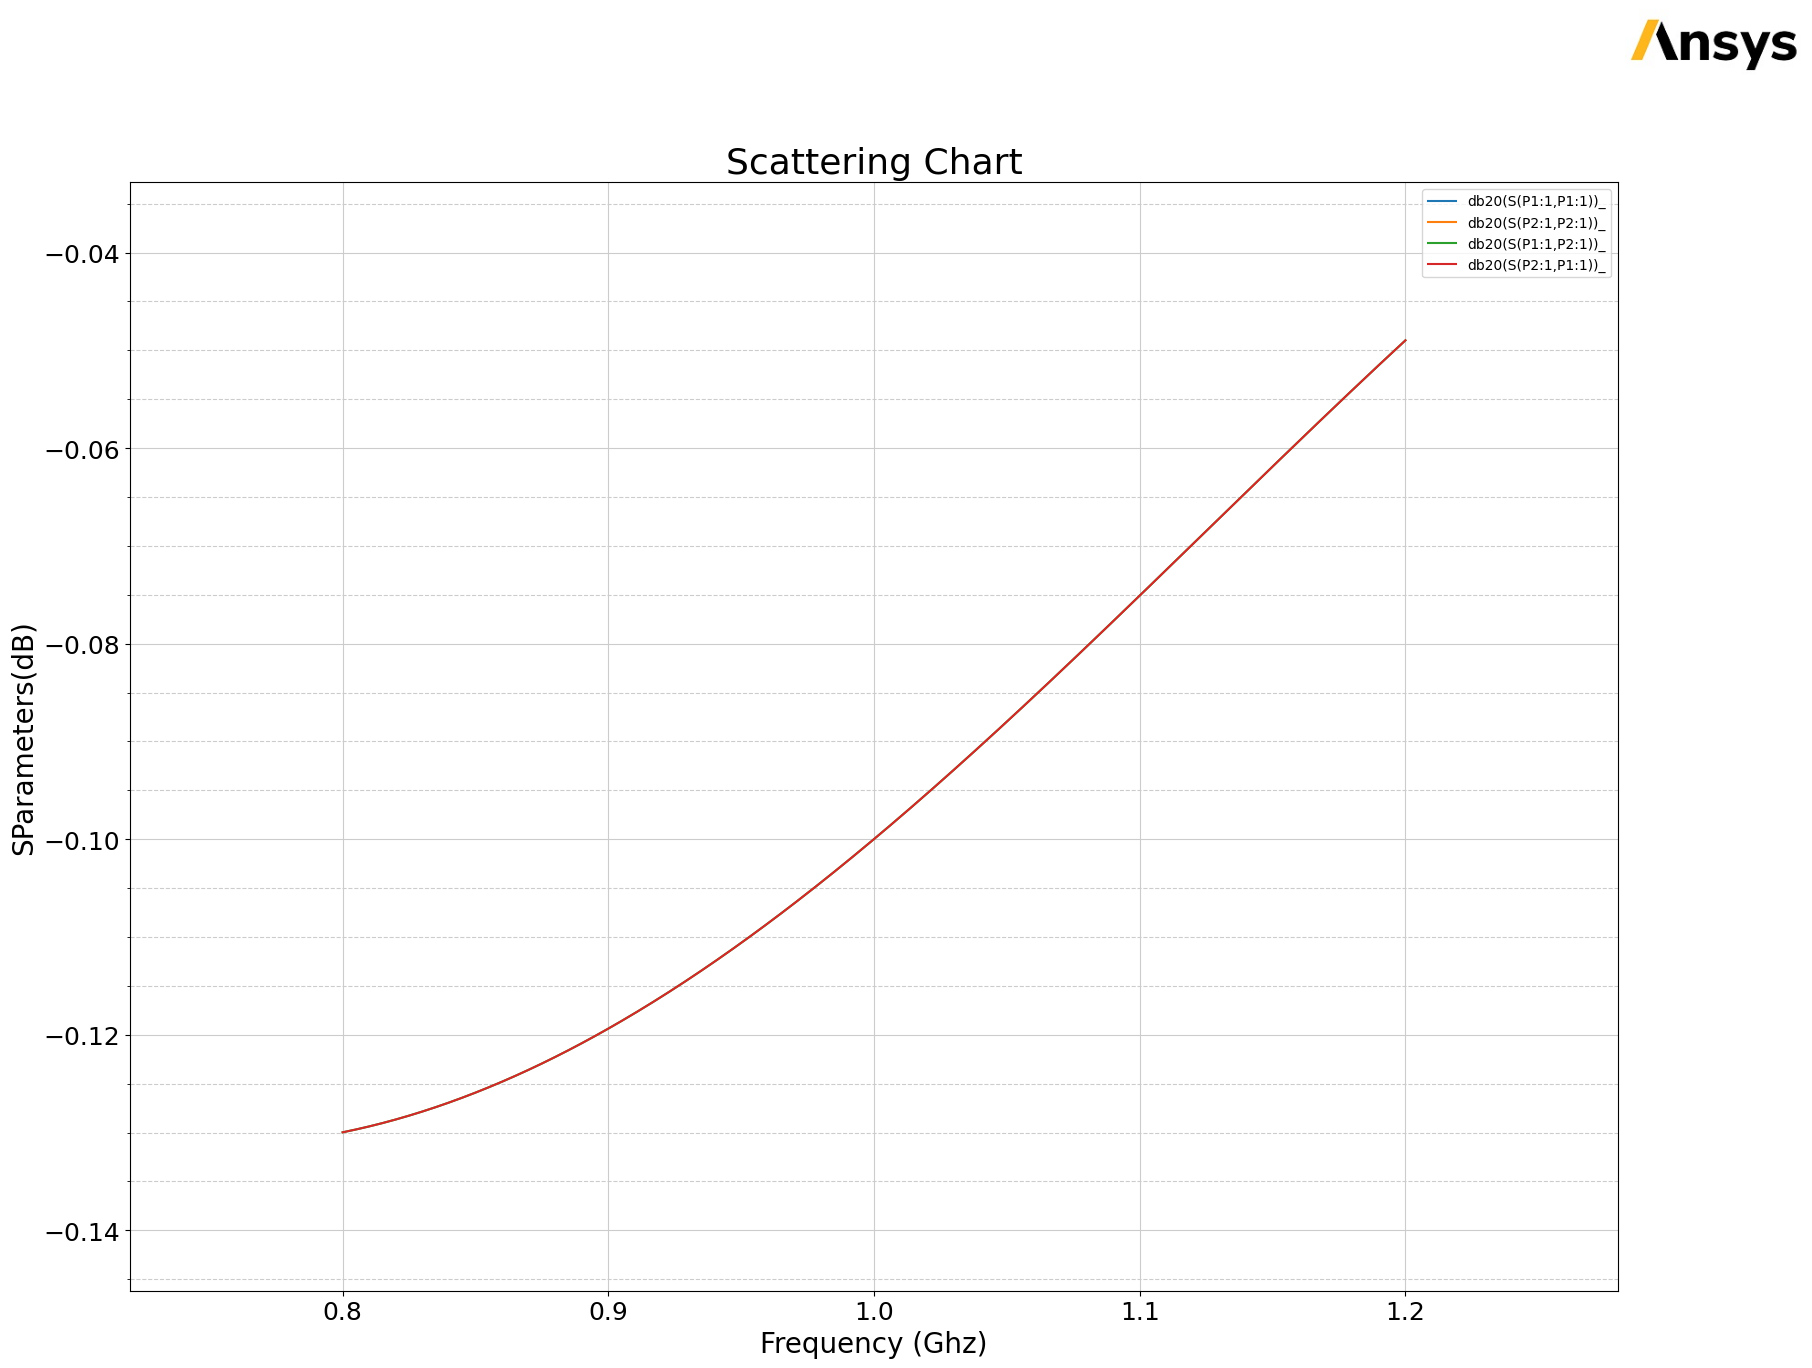

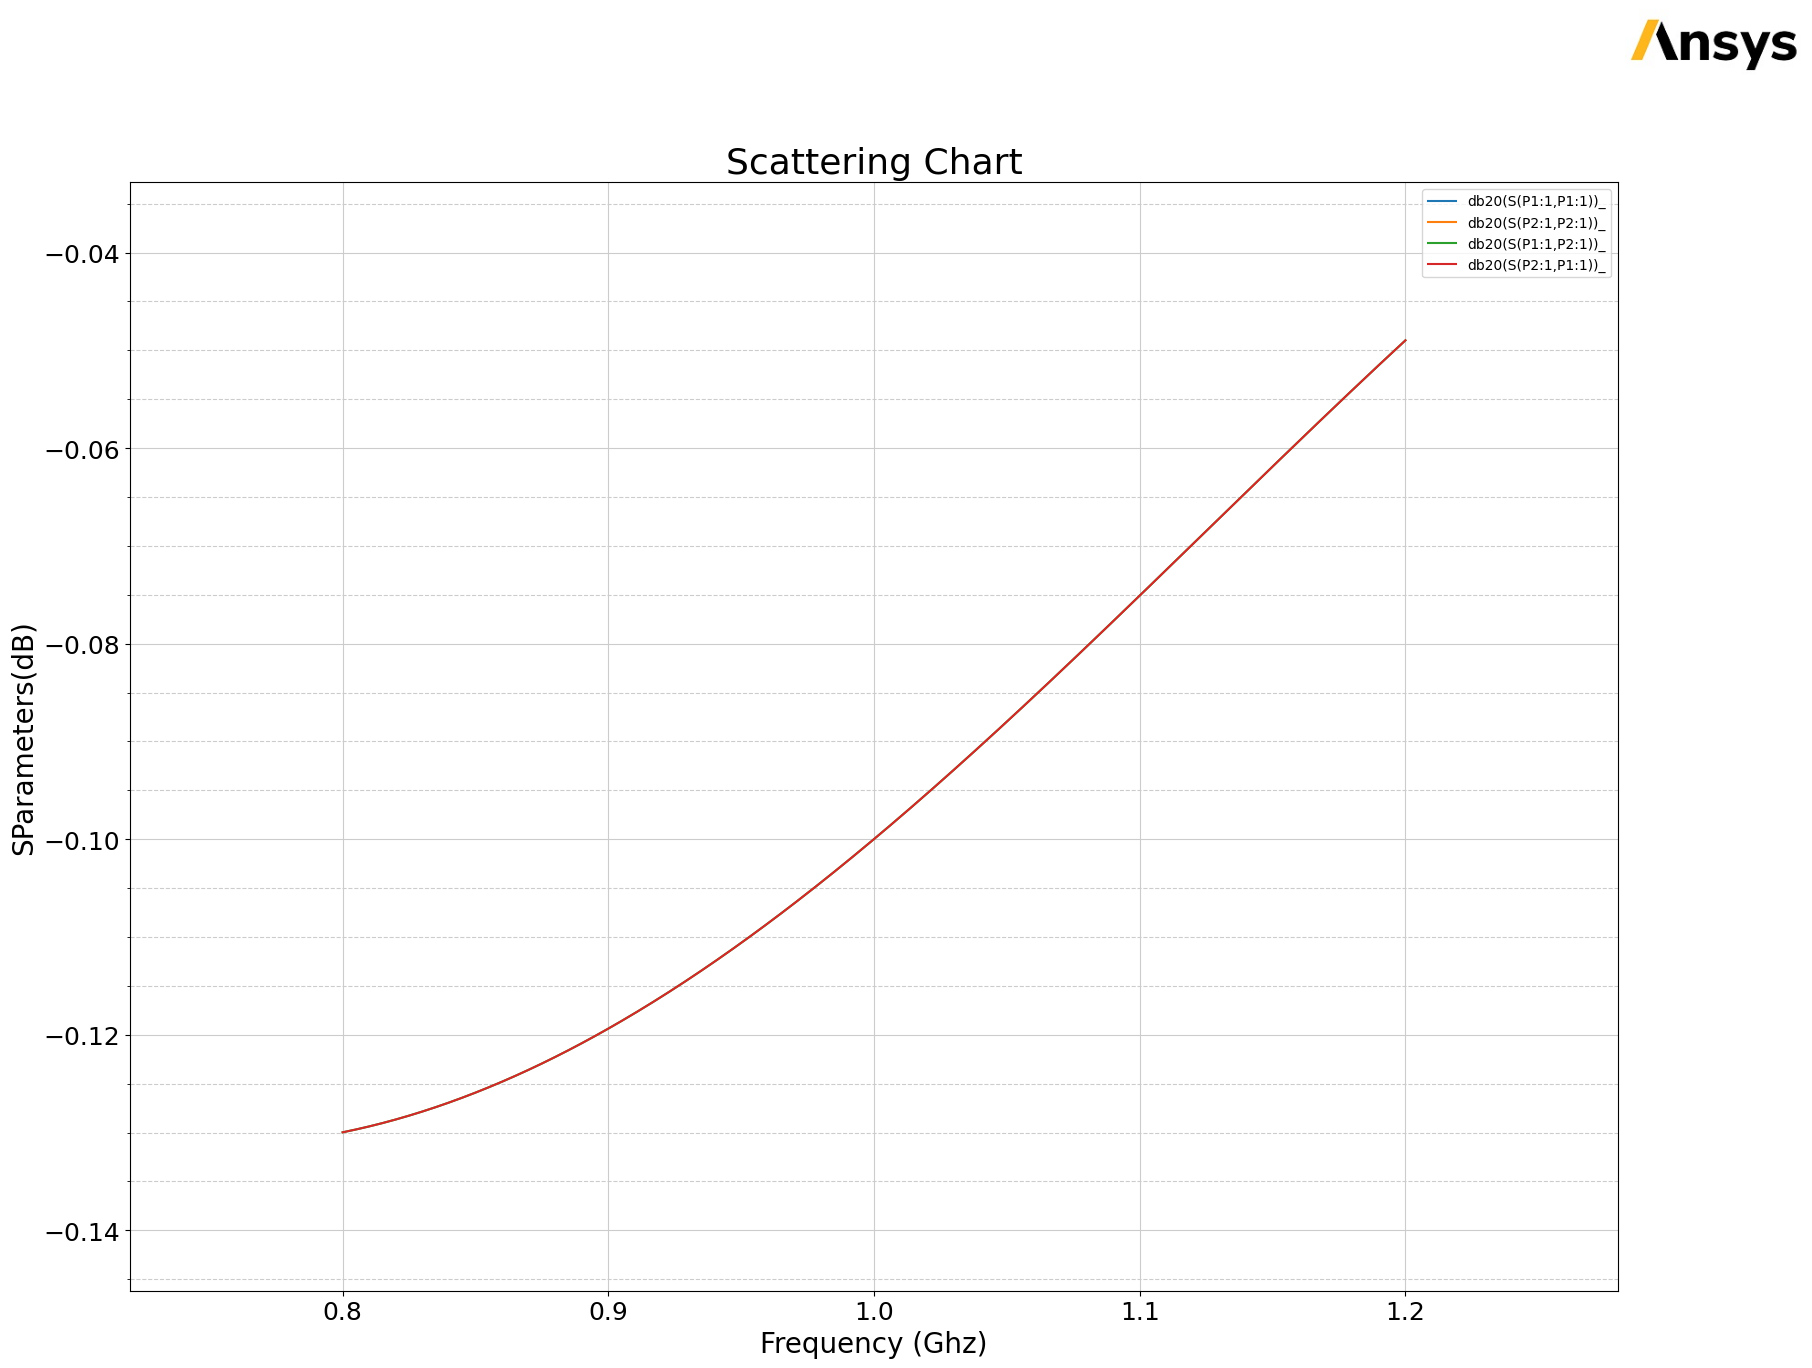

In [26]:
trace_names = hfss.get_traces_for_plot(category="S")
context = ["Domain:=", "Sweep"]
families = ["Freq:=", ["All"]]
my_data = hfss.post.get_solution_data(expressions=trace_names)
my_data.plot(
    trace_names,
    formula="db20",
    x_label="Frequency (Ghz)",
    y_label="SParameters(dB)",
    title="Scattering Chart",
    snapshot_path=os.path.join(temp_folder.name, "Touchstone_from_matplotlib.jpg"),
)

Create a PDF report summarizig results.

In [27]:
pdf_report = AnsysReport(
    project_name=hfss.project_name, design_name=hfss.design_name, version=AEDT_VERSION
)

Create the report.

In [28]:
pdf_report.create()

True

Add a section for plots.

In [29]:
pdf_report.add_section()
pdf_report.add_chapter("HFSS Results")
pdf_report.add_sub_chapter("Field plot")
pdf_report.add_text("This section contains field plots of HFSS Coaxial.")
pdf_report.add_image(
    os.path.join(temp_folder.name, plot1.name + ".jpg"), caption="Coaxial cable"
)

True

Add a page break and a subchapter for S Parameter results.

In [30]:
pdf_report.add_page_break()
pdf_report.add_sub_chapter("S Parameters")
pdf_report.add_chart(
    x_values=my_data.intrinsics["Freq"],
    y_values=my_data.data_db20(),
    x_caption="Freq",
    y_caption=trace_names[0],
    title="S-Parameters",
)
pdf_report.add_image(
    path=os.path.join(temp_folder.name, "Touchstone_from_matplotlib.jpg"),
    caption="Touchstone from Matplotlib",
)

True

Add a new section for Icepak results.

In [31]:
pdf_report.add_section()
pdf_report.add_chapter("Icepak Results")
pdf_report.add_sub_chapter("Temperature Plot")
pdf_report.add_text("This section contains Multiphysics temperature plot.")

Add table of content and save the PDF.

In [32]:
pdf_report.add_toc()
pdf_report.save_pdf(file_path=temp_folder.name, file_name="AEDT_Results.pdf")

'C:\\Users\\ansys\\AppData\\Local\\Temp\\tmprzn2hvcr.ansys\\AEDT_Results.pdf'

## Release AEDT

Release AEDT and close the example.

In [33]:
ipk.save_project()
hfss.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project Icepak_HFSS_Coupling Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``. If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell removes all temporary files, including the project folder.

In [34]:
temp_folder.cleanup()